# SSRM: Sequential Sample Ratio Mistmatch Test
## Michael Lindon (michael.lindon@optimizely.com)

## What is an SRM?

In almost all online controlled experiments (OCEs) which use random designs, one must specify a traffic allocation to each of the variants in the experiment. If you have never done this, chances are you have been using a default traffic allocation which assigns equal amounts of traffic to all the experiment variants.

A common cause for concern is when the number of visitors assigned to each variant appears somewhat different from what one might expect under the intended traffic allocation. Indeed, this is a signal of an underlying data quality issue or engineering bug in the implementation, which has the potential to invalidate any causal conclusions drawn from the experiment. Loosely speaking, a **Sample Ratio Mistmatch** (SRM) is said to be presented when the observed sample ratios are significantly different from the expected sample ratios. It is widely regarded as a good experimentation practise to check experiments for SRMs. We can formulate this problem statistically to give a precise mathematical definition of an SRM.

## Statistical Model
The simplest example of an A/B test involves two variants, a control and a treatment, and equal traffic allocation to each. To be precise, a new visitor is assigned to the treatment with probability 0.5 upon entering the experiment. Statistically speaking, this assignment is an example of a $\text{Binomial}(1,p)$. The intended traffic allocation corresponds to the *null hypothesis:* $p = 0.5$.  Detection of a sample ratio mismatch can be formulated as a hypothesis test which tests precisely this null hypothesis.

A more general example is provided when there are multiple variants in an experiment to assign visitors to randomly. In this case a user assignment is an example of a $\text{Multinomial}(1,p)$ random variable $x$, which is simply a higher dimensional generalization of the $\text{Binomial}(1,p)$ distribution. If there are $d$ variants in the experiment, then $x$ is a vector of length $d$ containing $d-1$ zeros and $1$ one to indicate the outcome. As an example $x=(0,0,1)$ indicates that the user was assigned to the third variant. Naturally, the parameter $p$ is also a $d$ dimensional vector, with the constraint that the elements are in $[0,1]$ and sum to 1, so that these values correspond to probabilities. The intended traffic allocation to each arm corresponds to a null hypothesis about the parameter $p$. If we expected equal traffic to each variant, then the null hypothesis is $p=[1/3, 1/3, 1/3]$.

$$\begin{align}
H_0: x_1, x_2, \dots \sim \text{Multinomial}(1,p)\hspace{1cm}p=p_0\\
H_1: x_1, x_2, \dots \sim \text{Multinomial}(1,p)\hspace{1cm}p\neq p_0\\
\end{align}$$

There are a number of ways to test this, Bayesian and frequentist, sequential and non sequential. The ssrm package contains a test developed at Optimizely which is sequential and has both Bayesian and frequentist interpretations. 

## SSRM
The wonderful thing about a sequential version of a sample ratio test is that you don't have to wait for the test to finish before it can be executed. The SSRM test detects in real time, from the very beginning of an experiment, if an SRM is present. This allows bugs to be rapidly detected in the early stages of an experiment and corrected, before exposing new users to the variants. For the underlying mathematical details, the reader is referred to our paper. Let's start off and generate some data to work with.

In [7]:
from scipy.stats import multinomial
import numpy as np

# Set the seed of our random number generator for reproducibility. Don't worry about this
np.random.seed(0)

# Our intended allocation probabilities
p_0 = [0.1, 0.5, 0.4]

# The actual allocation probabilities
p = [0.1, 0.49, 0.41]

# Specify number of visitors
N = 100000

# Generate allocations
data = multinomial.rvs(1, p, size=N)

array([10092, 48925, 40983])

We have just simulated N allocations under probabilities which differ from the intended. The null hypothesis is therefore not correct for this dataset, and we would like to reject the null hypothesis using the ssrm test. 

The ssrm package supports both sequential Bayesian and sequential Frequentist analyses. There is a tuning parameter for both, but a good default has been supplied for most users. 

Let's quickly install matplotlib and pandas for visualizing data. Simply uncomment the below code if necessary.

In [8]:
# import sys
#!{sys.executable} -m pip install matplotlib

## Frequentist Analysis
To obtain sequential p-values, simply import the `sequential_p_values` function. The probability under the null hypothesis that the sequential p-value falls below $\alpha$ is less than $\alpha$. In otherwords, if you reject the null and declare an SRM to be present when the sequential p-value is less than $\alpha$, then the probability of reporting a **false positive** is at most $\alpha$. 

In [9]:
from ssrm_test.ssrm_test import sequential_p_values
import matplotlib.pyplot as plt

pvals = sequential_p_values(data, p_0)

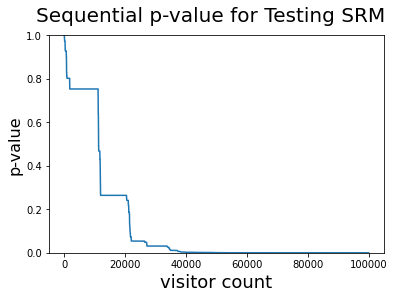

In [10]:
fig = plt.figure()
plt.plot(pvals)
fig.suptitle("Sequential p-value for Testing SRM", fontsize=20)
plt.xlabel("visitor count", fontsize=18)
plt.ylabel("p-value", fontsize=16)
plt.ylim(0, 1)
plt.show()

## Bayesian Analysis
One posterior probabilities (of an SRM) in the following way

In [11]:
from ssrm_test.ssrm_test import (
    sequential_bayes_factors,
    sequential_posterior_probabilities,
)

posterior_probabilities = sequential_posterior_probabilities(data, p_0)

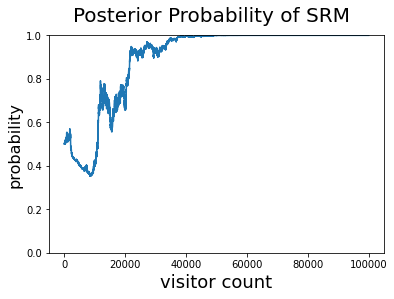

In [12]:
fig = plt.figure()
plt.plot(posterior_probabilities)
fig.suptitle("Posterior Probability of SRM", fontsize=20)
plt.xlabel("visitor count", fontsize=18)
plt.ylabel("probability", fontsize=16)
plt.ylim(0, 1)
plt.show()

## The Advantages of a Sequential Test
Consider the following tweet in which the user identifies an SRM using a non sequential frequentist test.

<img src="./images/kohavi.png" width=500></img>

Let's recreate the non sequential test here in this notebook. The user has noticed $x=821588$ visitors assignmened to the treatment out of a total $n=821588+815482$ visitors. The null hypothesis is that $p=0.5$. Let's compute the p-value from a two sided likelihood ratio test.

In [13]:
from scipy.stats import binom

x = 821588
n = 815482 + 821588
print("The non sequential p-value is {}".format(2 * binom.sf(x, n, 0.5)))

The non sequential p-value is 1.814686785224517e-06


The user has been able to identify an SRM at the 0.05-alpha level test by using a standard likelihood ratio test at the end of the experiment. Note that this happened at the **end of the experiment**. Unfortunately, this dataset is now invalid for testing and this large experiment of $1637070$ visitors has gone to waste. One needs to fix the underlying issue and start a new experiment, collecting new data.

Ideally one wouldn't have to wait until the end of an experiment to test if there is an SRM, and this is exactly the value add that the ssrm test provides - it is able to test for an SRM after **every single visitor** (without inflating the false positive rate). Let's generate a set of data which is consistent with the above example.

In [44]:
from random import shuffle

n_treatment = 821588
n_control = 815482
ones = [[0, 1]] * n_treatment
zeros = [[1, 0]] * n_control
combined = ones + zeros
shuffle(combined)
data = np.array(combined)
print(data[1:5])
print(
    "In total, there are {} visitors assigned to the treatment, and {} assigned to the control".format(
        n_treatment, n_control
    )
)

[[1 0]
 [0 1]
 [1 0]
 [0 1]]
In total, there are 821588 visitors assigned to the treatment, and 815482 assigned to the control


Computing... (this may take some time)


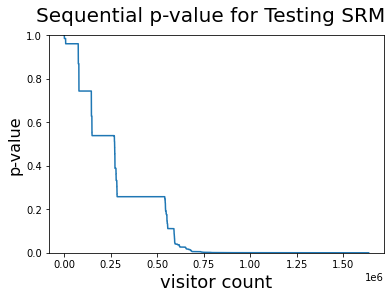

In [48]:
print("Computing... (this may take some time)")
pvals = sequential_p_values(data, [0.5, 0.5])
fig = plt.figure()
plt.plot(pvals)
fig.suptitle("Sequential p-value for Testing SRM", fontsize=20)
plt.xlabel("visitor count", fontsize=18)
plt.ylabel("p-value", fontsize=16)
plt.ylim(0, 1)
plt.show()

In [63]:
sig_reached = len([p for p in pvals if p > 0.05])
print(
    "SSRM rejected the null (no SRM) at the alpha=0.05 level after {} visitors.".format(
        sig_reached
    )
)
print(
    "That is only {}% of the way through the experiment.".format(
        round(100 * sig_reached / n), 3
    )
)

SSRM rejected the null (no SRM) at the alpha=0.05 level after 593568 visitors.
That is only 36% of the way through the experiment


As illustrated with the above example, SSRM allowed us to detect an SRM much sooner than the end of the experiment. Larger SRM's, and hence larger errors, are detected even sooner.

## Time Aggregated Data
Users may not have visitor level data, but time aggregated data instead. For instance, a user might only know the total number of visitors assigned to each variant with an interval of time. For 3 variants, such data can be represented as $[[100,120,99], [123,112,111], \dots$, where there is one inner array for each time bucket. Fortunately, the API is identical. 

In [91]:
from scipy.stats import poisson

# Set the seed of our random number generator for reproducibility. Don't worry about this
np.random.seed(0)

# Our intended allocation probabilities
p_0 = [0.1, 0.5, 0.4]

# The actual allocation probabilities
p = [0.1, 0.49, 0.41]

# Generate allocations
data = multinomial.rvs(1000, p, size=100)

print("Now the data looks like: ")
print(data[1:10])

Now the data looks like: 
[[102 497 401]
 [122 483 395]
 [101 513 386]
 [118 483 399]
 [ 93 516 391]
 [109 497 394]
 [104 506 390]
 [ 90 528 382]
 [104 516 380]]


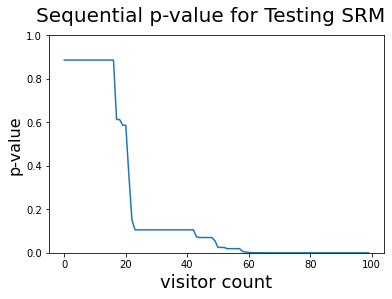

In [94]:
pvals = sequential_p_values(data, p_0)
fig = plt.figure()
plt.plot(pvals)
fig.suptitle("Sequential p-value for Testing SRM", fontsize=20)
plt.xlabel("visitor count", fontsize=18)
plt.ylabel("p-value", fontsize=16)
plt.ylim(0, 1)
plt.show()

## Working With Pandas DataFrames
Suppose your data is inside a pandas dataframe. The following cells will show you how to manipulate them into the format expected by the ssrm api. First, install pandas if you have not already done so, and lets create a dataframe to work with.

In [108]:
# import sys
#!{sys.executable} -m pip install pandas

import pandas as pd

df = pd.DataFrame(data)
df.columns = ["variation_a", "variation_b", "variation_c"]
df.head()

,variation_a,variation_b,variation_c
0,84,489,427
1,102,497,401
2,122,483,395
3,101,513,386
4,118,483,399


The dataframe df gives us the total number of visitors assigned to each variation within an interval of time. It's very easy to extract these values using `df.values`. This gives an array of arrays, which can be fed into the ssrm api.

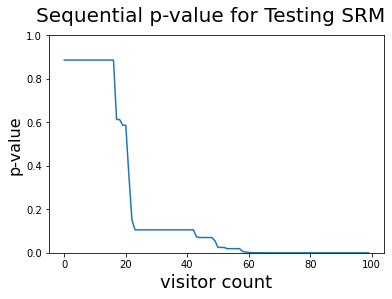

In [112]:
pvals = sequential_p_values(df.values, p_0)
fig = plt.figure()
plt.plot(pvals)
fig.suptitle("Sequential p-value for Testing SRM", fontsize=20)
plt.xlabel("visitor count", fontsize=18)
plt.ylabel("p-value", fontsize=16)
plt.ylim(0, 1)
plt.show()